In [1]:
from models.syncnet import SyncNet_color
from hparams import hparams
from functions import (
    face_detect, 
    read_frames_from_file, 
    compute_mel_spectrogram,
)

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

import librosa
import numpy as np
import cv2

%load_ext autoreload
%autoreload 2

/Users/johnathanchiu/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SyncNet_color()

checkpoint = torch.load(
    "/Users/johnathanchiu/Projects/Wav2Lip/weights/lipsync_expert.pth",
    map_location=torch.device("cpu"),
)
model.load_state_dict(checkpoint["state_dict"])
model = model.eval()

In [3]:
# from pytube import YouTube

# def download(url):
#     video = YouTube(url)
#     video.streams.get_by_itag(18).download()
#     print("Downloaded!")
    
# download("https://www.youtube.com/watch?v=jNxpVIHbzpA")

# Command to segment video 
# !ffmpeg -ss 00:11:24 -to 00:11:26 -i test_vid1.mp4 -c copy test_vid_cropped1.mp4
# # Download 24 FPS video so assume FR is negligible

TEST_VIDEO = "test_vid_cropped1.mp4"

In [6]:
### Run face detection ###

frames = read_frames_from_file(TEST_VIDEO)
detected_faces = face_detect(frames, **{"batch_size": 1, "max_frames": 25, "nosmooth": True})

# # list of list of detected faces per frame

Reading video frames...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.35s/it]
/Users/johnathanchiu/Projects/Wav2Lip/functions.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(results)


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

Extracting raw audio...


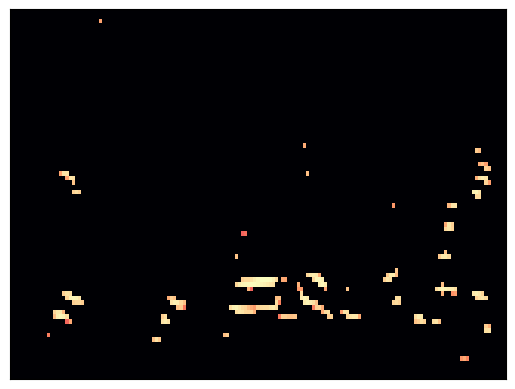

In [7]:
S = compute_mel_spectrogram(TEST_VIDEO, hparams.sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

In [8]:
@torch.no_grad()
def embed_faces(model, face_sequences):
    face_embedding = model.face_encoder(face_sequences)
    face_embedding = face_embedding.view(face_embedding.size(0), -1)
    face_embedding = F.normalize(face_embedding, p=2, dim=1)
    return face_embedding.squeeze(0)
   
@torch.no_grad()
def embed_audio(model, audio_sequences):
    audio_embedding = model.audio_encoder(audio_sequences)
    audio_embedding = audio_embedding.view(audio_embedding.size(0), -1)
    audio_embedding = F.normalize(audio_embedding, p=2, dim=1)
    return audio_embedding.squeeze(0)

def cosine_similiarity(A, B):
    return np.dot(A,B) / (np.linalg.norm(A, axis=0)*np.linalg.norm(B))

In [9]:
def preprocess_frames(frames, hparams):
    # H x W x 3 * T
    frames = [
        cv2.resize(f, (hparams.img_size, hparams.img_size)) for f in frames
    ]
    x = np.concatenate(frames, axis=2) / 255.
    x = x.transpose(2, 0, 1)
    x = x[:, x.shape[1]//2:]

    return torch.FloatTensor(x)

def preprocess_audio(mel, start, syncnet_mel_step_size):
    mel = mel.T[start:start + syncnet_mel_step_size]
    mel = torch.FloatTensor(mel.T).unsqueeze(0)
    return mel

In [10]:
# Test that a single segment works

syncnet_mel_step_size = 16

which_face = 0

faces_in = preprocess_frames([d[which_face][0] for d in detected_faces[:5]], hparams)
audio_in = preprocess_audio(S, 0, syncnet_mel_step_size)

A = embed_faces(model, faces_in.unsqueeze(0))
B = embed_audio(model, audio_in.unsqueeze(0))

cosine_similiarity(A, B)

0.006748046

In [11]:
audio_in.shape, faces_in.shape

(torch.Size([1, 80, 16]), torch.Size([15, 48, 96]))

In [12]:
S.shape, len(detected_faces)

((80, 161), 25)

/var/folders/pj/3l6r37v558dg9qvx0ytwsrbw0000gn/T/ipykernel_39344/2384891866.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


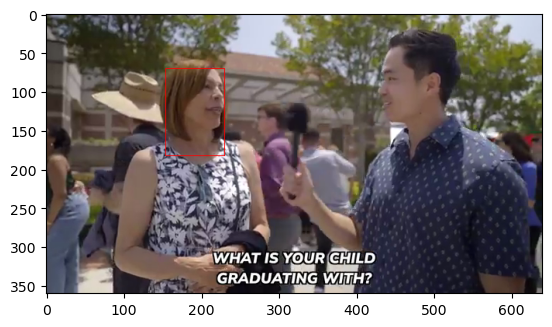

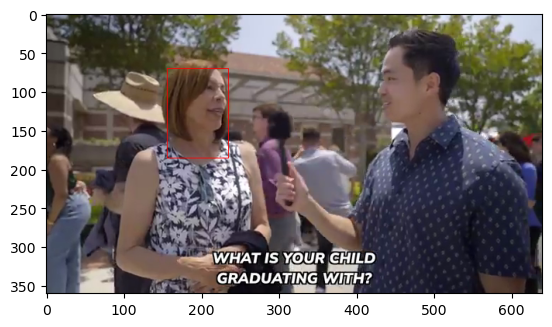

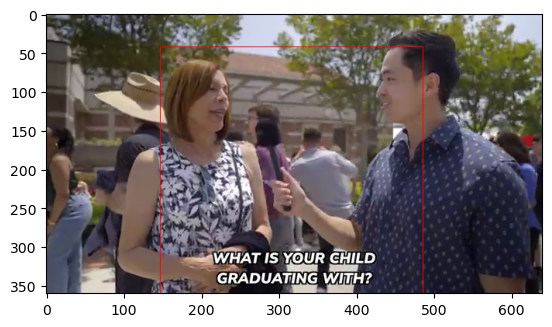

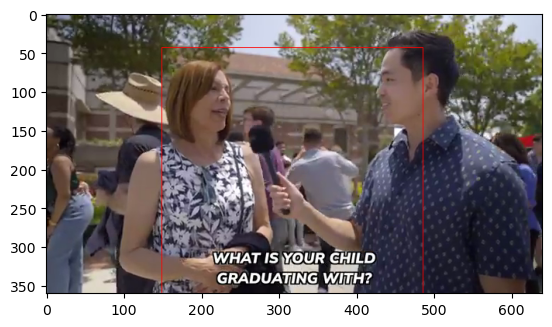

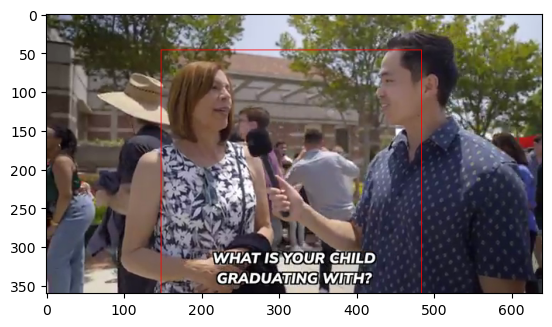

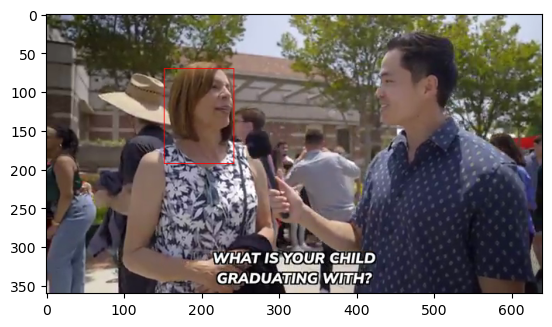

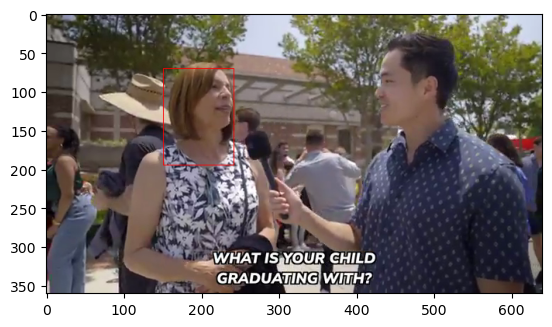

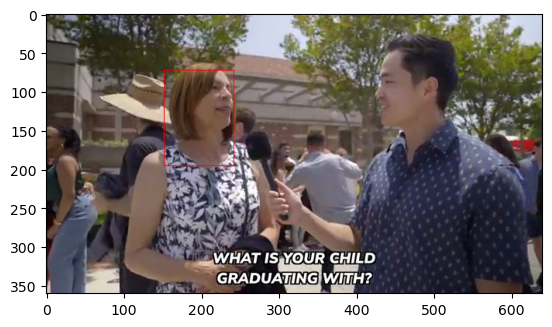

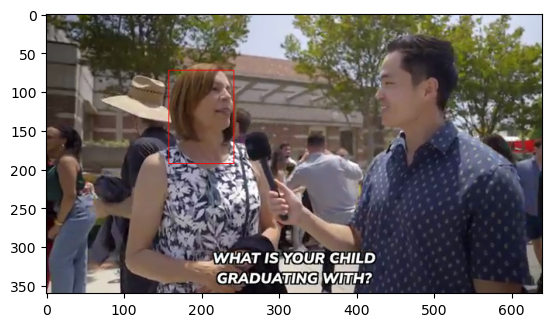

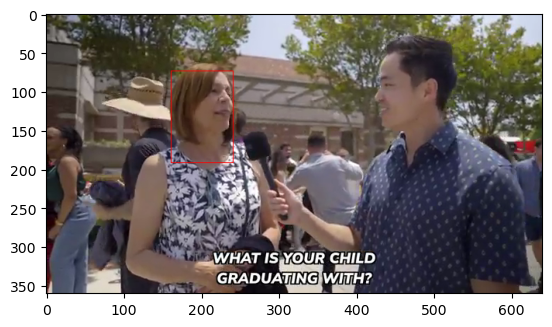

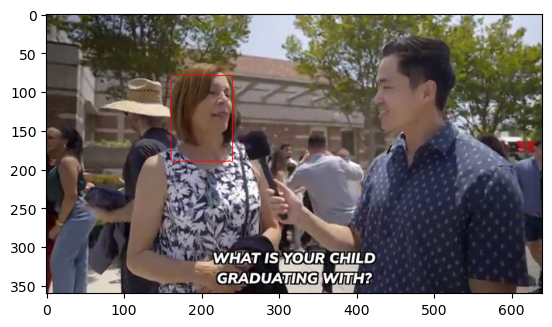

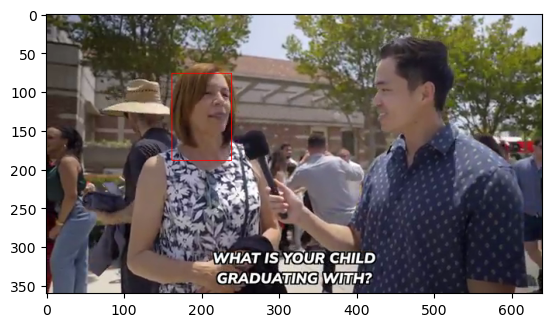

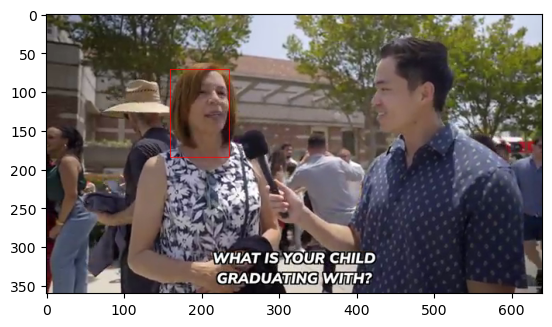

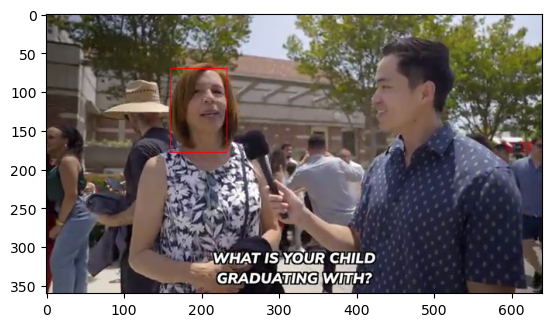

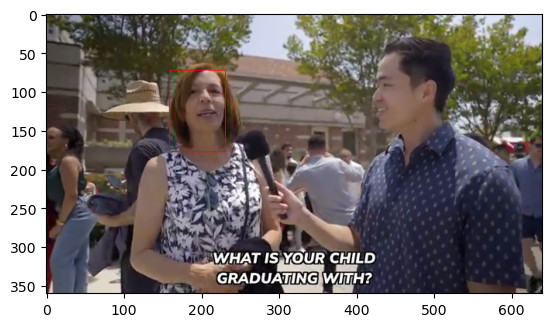

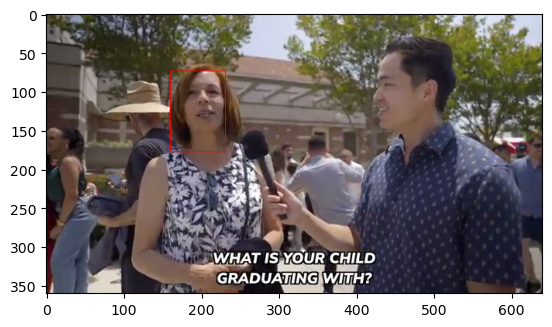

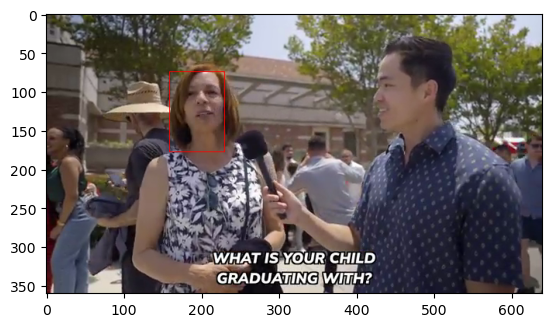

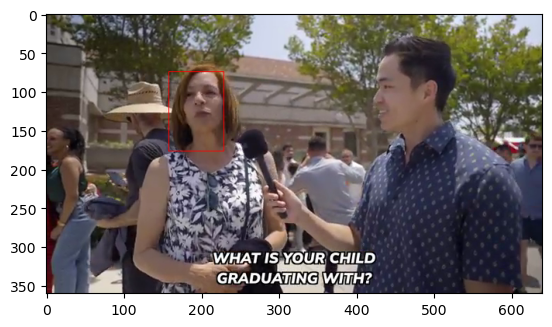

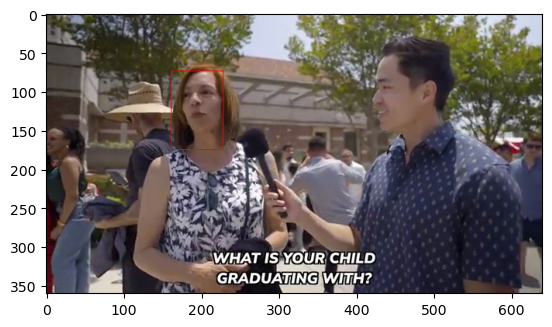

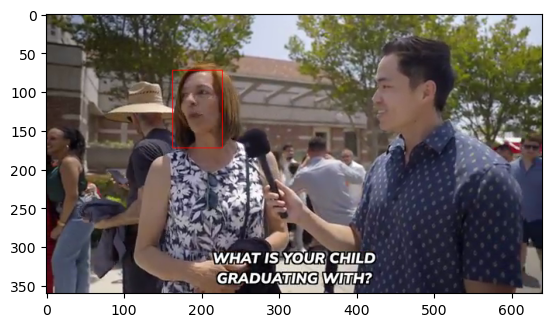

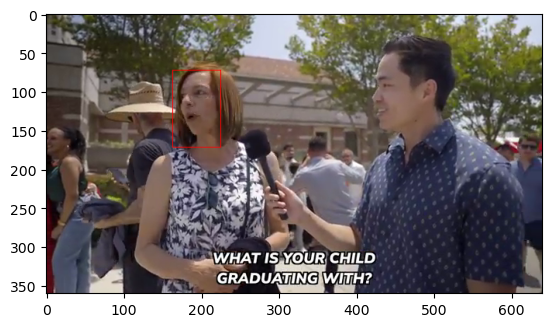

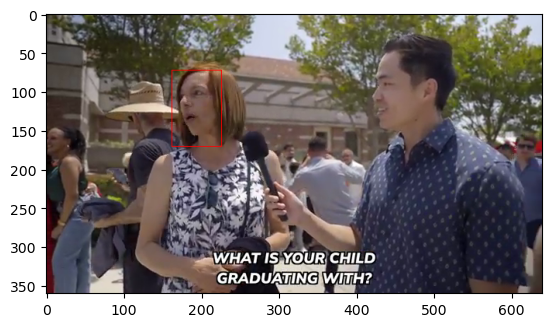

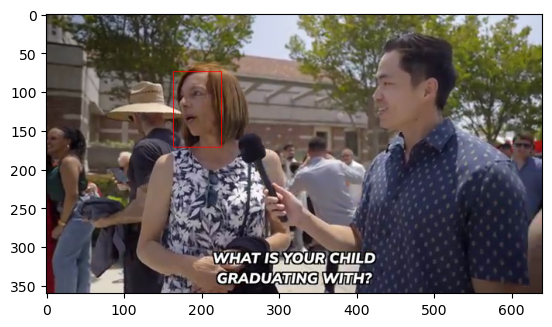

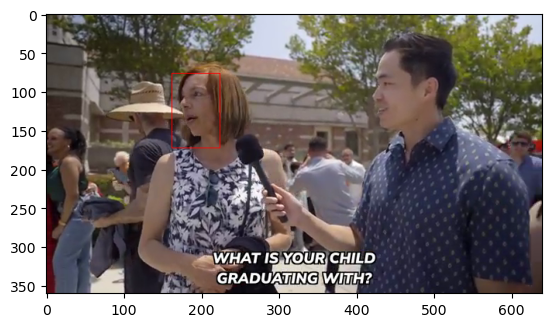

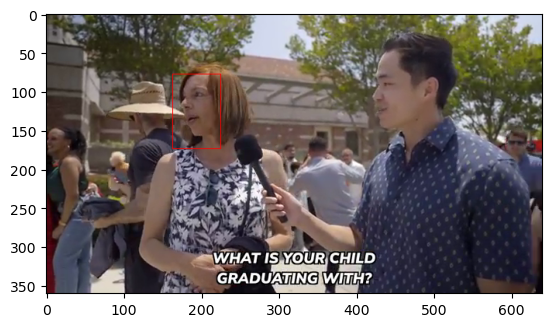

In [13]:
NUM_FACES = 2

def grab_speaker(detected_faces, start, audio):
    # Compute audio embeddings
    audio_in = preprocess_audio(S, start, syncnet_mel_step_size)
    audio_embedding = embed_audio(model, audio_in.unsqueeze(0))
    
    # Compute face embeddings
    face_embeddings = []
    for j in range(NUM_FACES):
        faces = [detected_faces[i][j][0] for i in range(len(detected_faces))]
        bounding_boxes = [detected_faces[i][j][1] for i in range(len(detected_faces))]
        faces_in = preprocess_frames(faces, hparams)
        face_embedding = embed_faces(model, faces_in.unsqueeze(0))
        face_embeddings.append((face_embedding, bounding_boxes))
    
    idx = np.argmax([cosine_similiarity(audio_embedding, fe) for fe, _ in face_embeddings])
        
    return face_embeddings[idx][1]

T = 5
speaker_per_segment = []
segment_num = 0
for i in range(0, len(detected_faces), T):
    audio_count = syncnet_mel_step_size * segment_num
    vid_segment = detected_faces[i:i+T]
    segment_num += 1
    speaker_per_segment.append(grab_speaker(vid_segment, audio_count, S))
    
f_num = 0
for segment in speaker_per_segment:
    for box in segment:
        frame = frames[f_num][...,::-1]
        start_point = box[:2][::-1]
        end_point = box[2:][::-1]
        frame = cv2.rectangle(frame.astype(np.uint8), start_point, end_point, (255, 0, 0), 1)
        plt.figure()
        plt.imshow(frame)
        f_num += 1